In [1]:
import JupyterNotebooksLib as slicernb

In [2]:
this_notebook_name = "SpineSegmentationVisualTest"

# place path to scene to test here
scene_to_reconstruct = r"C:\Users\perkl\Documents\AIGT\SpineUsOutput\722_Sa_Ready.mrb"

# set this to the name of the model to study
model_fullname = r"c:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy-TF2_model-4_2020-06-23_19-47-30.h5"

# set this to notebook folder
notebooks_save_fullpath = r"C:\Data\SagittalSpineSegmentationStudy\SavedNotebooks"

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

Save timestamp: 2020-06-25_14-11-48


In [3]:
slicer.mrmlScene.Clear()
try:
    slicer.util.loadScene(scene_to_reconstruct)
except:
    # NOTE: for some reason loading a scene throws an error every time, but laods the scene just fine
    print('Error thrown. Continuing.')
    

In [4]:
# changing transform hierarchy
image_image = slicer.util.getFirstNodeByName("Image_Image")
imageToTransd = slicer.util.getFirstNodeByName("ImageToTransd")

image_image.SetAndObserveTransformNodeID(None)
image_image.SetAndObserveTransformNodeID(imageToTransd.GetID())

True

In [5]:
# Input ultrasound sequence names

input_browser_name = r"LandmarkingScan"
input_image_name = r"Image_Image"

# Output will be saved using these names

output_browser_name = r"BonePredictionBrowser"
output_sequence_name = r"PredictionSequence"
output_image_name = r"PredictionImage"

# Optionally save output to numpy arrays

array_output = False
array_folder_name = r"Temp"
array_segmentation_name = r"segmentation"
array_ultrasound_name = r"ultrasound"

# Image processing parameters

# Erases the side of prediction images. 1.0 means the whole prediction is erased.
# Background should be the first component (i.e. y[:,:,:,0]) in the prediction output array.

clip_side_ratio = 0.3
apply_logarithmic_transformation = True
logarithmic_transformation_decimals = 4

In [6]:
import datetime
import numpy as np
import os
import scipy.ndimage

import tensorflow as tf
from tensorflow.keras.models import load_model

# from local_vars import root_folder

In [7]:
# The aigt repository needs to be cloned in this folder
import aigt.Models.segmentation_unet as unet
import aigt.utils

In [8]:
# Check if keras model file exists. Abort if not found. Load model otherwise.

if not os.path.exists(model_fullname):
    raise Exception("Could not find model: " + model_fullname)

print("Loading model from: " + model_fullname)

if array_output:
    array_output_fullpath = os.path.join(root_folder, array_folder_name)
    array_segmentation_fullname = os.path.join(array_output_fullpath, array_segmentation_name)
    array_ultrasound_fullname = os.path.join(array_output_fullpath, array_ultrasound_name)
    if not os.path.exists(array_output_fullpath):
        os.mkdir(array_output_fullpath)
        print("Folder created: {}".format(array_output_fullpath))
    print("Will save segmentation output to {}".format(array_segmentation_fullname))
    print("Will save ultrasound output to   {}".format(array_ultrasound_fullname))

model = tf.keras.models.load_model(model_fullname, compile=False)

# model.summary()

Loading model from: c:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy-TF2_model-4_2020-06-23_19-47-30.h5


In [9]:
# Check input. Abort if browser or image doesn't exist.

input_browser_node = slicer.util.getFirstNodeByName(input_browser_name, className='vtkMRMLSequenceBrowserNode')
input_image_node = slicer.util.getFirstNodeByName(input_image_name, className="vtkMRMLScalarVolumeNode")

if input_browser_node is None:
    logging.error("Could not find input browser node: {}".format(input_browser_node))
    raise

if input_image_node is None:
    logging.error("Could not find input image node: {}".format(input_image_name))
    raise

In [10]:
# Create output image and browser for segmentation output.

output_browser_node = slicer.util.getFirstNodeByName(output_browser_name, className='vtkMRMLSequenceBrowserNode')
if output_browser_node is None:
    output_browser_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSequenceBrowserNode', output_browser_name)

output_sequence_node = slicer.util.getFirstNodeByName(output_sequence_name, className="vtkMRMLSequenceNode")
if output_sequence_node is None:
    output_sequence_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSequenceNode', output_sequence_name)
    output_browser_node.AddSynchronizedSequenceNode(output_sequence_node)

output_image_node = slicer.util.getFirstNodeByName(output_image_name, className="vtkMRMLScalarVolumeNode")
if output_image_node is None:
    volumes_logic = slicer.modules.volumes.logic()
    output_image_node = volumes_logic.CloneVolume(slicer.mrmlScene, input_image_node, output_image_name)
    browser_logic = slicer.modules.sequences.logic()
    browser_logic.AddSynchronizedNode(output_sequence_node, output_image_node, output_browser_node)

output_browser_node.SetRecording(output_sequence_node, True)

In [11]:
# Add all input sequences to the output browser for being able to conveniently replay everything

proxy_collection = vtk.vtkCollection()
input_browser_node.GetAllProxyNodes(proxy_collection)

for i in range(proxy_collection.GetNumberOfItems()):
    proxy_node = proxy_collection.GetItemAsObject(i)
    output_sequence = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSequenceNode')
    browser_logic.AddSynchronizedNode(output_sequence, proxy_node, output_browser_node)
    output_browser_node.SetRecording(output_sequence, True)

In [12]:
# Iterate input sequence, compute segmentation for each frame, record output sequence.

num_items = input_browser_node.GetNumberOfItems()
n = num_items
input_browser_node.SelectFirstItem()

input_array = slicer.util.array(input_image_node.GetID())
slicer_to_model_scaling = model.layers[0].input_shape[0][1] / input_array.shape[1]
model_to_slicer_scaling = input_array.shape[1] / model.layers[0].input_shape[0][1]

print("Will segment {} images".format(n))

if array_output:
    array_output_ultrasound = np.zeros((n, input_array.shape[1], input_array.shape[1]))
    array_output_segmentation = np.zeros((n, input_array.shape[1], input_array.shape[1]), dtype=np.uint8)

Will segment 688 images


In [13]:
model_output_size = model.layers[-1].output_shape[1]
num_output_components = model.layers[-1].output_shape[3]

mask_model = np.ones([model_output_size, model_output_size])
mask_model_background = np.zeros([model_output_size, model_output_size])

columns_to_mask = int(model_output_size / 2 * clip_side_ratio)
print("Will mask {} columns on both sides".format(columns_to_mask))

mask_model[:,:columns_to_mask] = 0
mask_model[:,-columns_to_mask:] = 0
mask_model_background[:,:columns_to_mask] = 1
mask_model_background[:,-columns_to_mask:] = 1

# Display mask

# import matplotlib
# matplotlib.use('WXAgg')

# from matplotlib import pyplot as plt

# plt.imshow(mask_model[:,:])
# plt.show()

Will mask 19 columns on both sides


In [14]:
start_timestamp = datetime.datetime.now()
print("Processing started at: {}".format(start_timestamp.strftime('%H-%M-%S')))


for i in range(n):
    # if i > 10:  # todo Just for debugging
    #     break
    input_array = slicer.util.array(input_image_node.GetID())
    
    if array_output:
        array_output_ultrasound[i, :, :] = input_array[0, :, :]
    
    resized_input_array = scipy.ndimage.zoom(input_array[0,:,:], slicer_to_model_scaling)
    resized_input_array = np.flip(resized_input_array, axis=0)
    resized_input_array = resized_input_array / resized_input_array.max()  # Scaling intensity to 0-1
    resized_input_array = np.expand_dims(resized_input_array, axis=0)
    resized_input_array = np.expand_dims(resized_input_array, axis=3)
    y = model.predict(resized_input_array)
    if apply_logarithmic_transformation:
        e = logarithmic_transformation_decimals
        y = np.log10(np.clip(y, 10**(-e), 1.0)*(10**e))/e
    y[0,:,:,:] = np.flip(y[0,:,:,:], axis=0)
    
    for component in range(1, num_output_components):
        y[0,:,:,component] = y[0,:,:,component] * mask_model[:,:]
    y[0,:,:,0] = np.maximum(y[0,:,:,0], mask_model_background)
    
    upscaled_output_array = scipy.ndimage.zoom(y[0,:,:,1], model_to_slicer_scaling)
    upscaled_output_array = upscaled_output_array * 255
    upscaled_output_array = np.clip(upscaled_output_array, 0, 255)
    
    if array_output:
        array_output_segmentation[i, :, :] = upscaled_output_array[:, :].astype(np.uint8)
    
    # output_array = slicer.util.array(output_image_node.GetID())
    # output_array[0, :, :] = upscaled_output_array[:, :].astype(np.uint8)
    
    slicer.util.updateVolumeFromArray(output_image_node, upscaled_output_array.astype(np.uint8)[np.newaxis, ...])
    
    output_browser_node.SaveProxyNodesState()
    input_browser_node.SelectNextItem()
    
    # If Slicer crashes during processing, try commenting this following line out and run this notebook again.
    slicer.app.processEvents()


stop_timestamp = datetime.datetime.now()
print("Processing finished at: {}".format(stop_timestamp.strftime('%H-%M-%S')))


if array_output:
    np.save(array_ultrasound_fullname, array_output_ultrasound)
    np.save(array_segmentation_fullname, array_output_segmentation)
    print("Saved {}".format(array_ultrasound_fullname))
    print("Saved {}".format(array_segmentation_fullname))

Processing started at: 14-11-52
Processing finished at: 14-12-33


In [15]:
time_seconds = (stop_timestamp - start_timestamp).total_seconds()
print("Processed {} frames in {:.2f} seconds".format(n, time_seconds))
print("FPS = {:.2f}".format(n / time_seconds))

Processed 688 frames in 40.97 seconds
FPS = 16.79


In [16]:
# Find input volume (image) for volume reconstruction

predictionVolume = slicer.mrmlScene.GetFirstNodeByName("PredictionImage")
if predictionVolume is None:
    raise Exception("PredictionImage not found in Slicer scene")

In [17]:
# Create output volume node

reconstructedVolume = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
if reconstructedVolume is None:
    reconstructedVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
    reconstructedVolume.SetName("AiVolume")

In [18]:
inputBrowserNode = slicer.mrmlScene.GetFirstNodeByName("BonePredictionBrowser")
if inputBrowserNode is None:
    raise Exception("BonePredictionBrowser missing")

In [19]:
# Prepare volume reconstructor node

volumeReconstructor = slicer.mrmlScene.GetFirstNodeByName("AiVolumeReconstructor")
if volumeReconstructor is None:
    volumeReconstructor = slicer.vtkMRMLVolumeReconstructionNode()
    volumeReconstructor.SetName("AiVolumeReconstructor")
    volumeReconstructor.SetLiveVolumeReconstruction(False)
    volumeReconstructor.SetOptimizationMode(slicer.vtkMRMLVolumeReconstructionNode.FULL_OPTIMIZATION)
    volumeReconstructor.SetCompoundingMode(slicer.vtkMRMLVolumeReconstructionNode.MAXIMUM_COMPOUNDING_MODE)
    volumeReconstructor.SetInterpolationMode(slicer.vtkMRMLVolumeReconstructionNode.LINEAR_INTERPOLATION)
    slicer.mrmlScene.AddNode(volumeReconstructor)

volumeReconstructor.SetAndObserveInputSequenceBrowserNode(inputBrowserNode)
volumeReconstructor.SetAndObserveOutputVolumeNode(reconstructedVolume)
volumeReconstructor.SetAndObserveInputVolumeNode(predictionVolume)

volumeReconstructionLogic = slicer.modules.volumereconstruction.logic()

In [20]:
# Volume reconstruction

volumeReconstructionLogic.ReconstructVolumeFromSequence(volumeReconstructor)


In [21]:
# Volume rendering

# find input volume
aivolumeNode = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
if aivolumeNode is None:
    raise Exception("AiVolume node was never constructed")

In [22]:
# find or build ROI
annotationROINode = slicer.mrmlScene.GetFirstNodeByName("AnnotationROI")
if annotationROINode is None:
    annotationROINode = slicer.vtkMRMLAnnotationROINode()
    annotationROINode.SetName("AnnotationROI")
    slicer.mrmlScene.AddNode(annotationROINode)
    annotationROINode.SetDisplayVisibility(False)

In [23]:
# find or build volume property
propertyPresetNode = slicer.mrmlScene.GetFirstNodeByName("volMR-Default")
if propertyPresetNode is None:
    propertyPresetNode = slicer.vtkMRMLVolumePropertyNode()
    propertyPresetNode.SetName("volMR-Default")
    volumeRenderingLogic = slicer.modules.volumerendering.logic()
    propertyPresetNode.Copy(volumeRenderingLogic.GetPresetByName('MR-Default'))
    slicer.mrmlScene.AddNode(propertyPresetNode)

In [24]:
# build 3D renderer
volumeRenderingLogic = slicer.modules.volumerendering.logic()
displayNode = volumeRenderingLogic.GetFirstVolumeRenderingDisplayNode(aivolumeNode)
if displayNode is None:
    displayNode = slicer.vtkMRMLGPURayCastVolumeRenderingDisplayNode()
    displayNode.SetName("AiVolumeRenderer")
    slicer.mrmlScene.AddNode(displayNode)
    
    aivolumeNode.AddAndObserveDisplayNodeID(displayNode.GetID())
    
    displayNode.SetAndObserveVolumePropertyNodeID(propertyPresetNode.GetID())
    displayNode.SetAndObserveROINodeID(annotationROINode.GetID())
    
displayNode.SetVisibility(True)
    

In [25]:
# remove RGY spine volume
to_hide = slicer.util.getFirstNodeByName("SkeletonModel")
to_hide.SetDisplayVisibility(False)

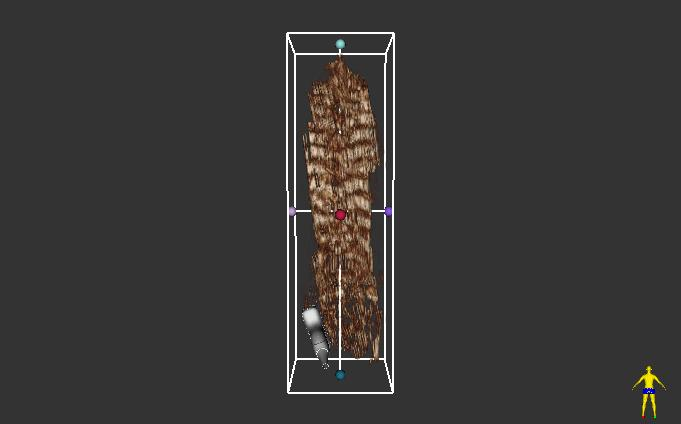

In [26]:
# reseting 3d camera
threeDWidget = slicer.app.layoutManager().threeDWidget(0)
threeDView = threeDWidget.threeDView()
threeDView.resetFocalPoint()


# displaying posterior view
slicer.app.layoutManager().setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutFourUpView)
slicernb.View3DDisplay()

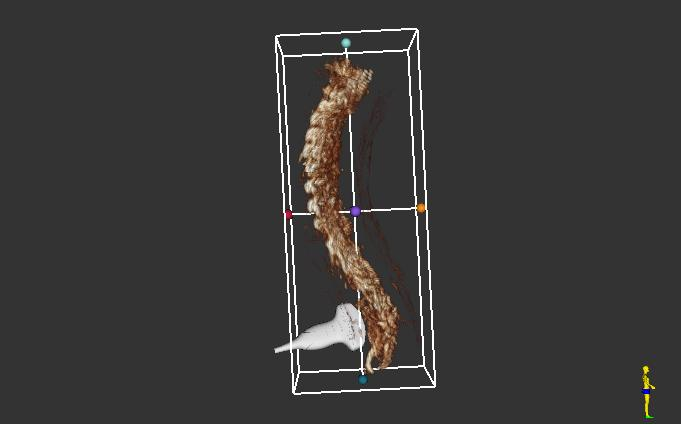

In [27]:
# displaying lateral view
layoutManager = slicer.app.layoutManager()
threeDWidget = layoutManager.threeDWidget(0)
threeDView = threeDWidget.threeDView()

for i in range (0, 18):
    threeDView.yaw()

slicernb.View3DDisplay()

In [30]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: C:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SpineSegmentationVisualTest_2020-06-25_14-11-48.html
